In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
# import h5py
# halo_fname = 'RShalos_allprops.hdf5'
# f = h5py.File(halo_fname,'r')
# halos = f['halos']
# #print(halos.dtype)
# mass = halos['m'] # which mass is this?
# sel = mass > 1e+13
# lnM = np.log(mass[sel])
# beta = 2 

In [23]:
%run /global/project/projectdirs/des/zhou/spt_selection/header.py

# Define exponential mass function

$n_{1}(\mu)=A e^{-\beta_{1} \mu}$

$\beta = 1.6$
$M_p = 1E12$

In [24]:
from scipy.stats import expon
beta = 1.6
lnM = expon.rvs(loc=np.log(1e12), scale=1/beta, size=10**8)
lnM = lnM[lnM > np.log(1e13)]

In [25]:
print(min(lnM), max(lnM))

29.933606282971596 39.82226226203406


Text(0, 0.5, 'Count')

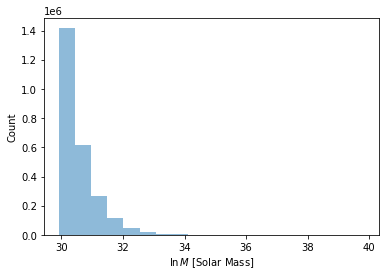

In [26]:
bins = np.linspace(min(lnM), max(lnM), 20)
plt.hist(lnM, alpha=0.5, label='exp', bins=bins)
plt.xlabel("$\ln M$ [Solar Mass]")
plt.ylabel("Count")
# plt.hist(lnM_real, density=True, alpha=0.5, label='HMF', bins=bins)
# plt.legend()
# plt.yscale('log')

In [27]:
%run /global/project/projectdirs/des/zhou/spt_selection/header.py

In [28]:
import copy
lnMwl_mean = copy.deepcopy(lnM)
nh = len(lnM)

In [29]:
lnlam_mean = alpha_lam*lnM + pi_lam
lnSZ_mean = alpha_SZ*lnM + pi_SZ

In [30]:
from scipy.stats import multivariate_normal
from scipy.stats import norm

In [31]:
lnlam_mean = alpha_lam*lnM + pi_lam
lnSZ_mean = alpha_SZ*lnM + pi_SZ

from scipy.stats import multivariate_normal
from scipy.stats import norm

# MonteCarlo

First, Monte Carlo from the covariance matrix and the mean. How does this work? 

Second, define a narrow richness bin to mimic the distribution of halo mass given richness. The expectation value given no correlation should be 
$$\frac{\lambda-\pi_{\lambda}}{\alpha_{\lambda}}$$

But the downward correction is 
$$-(\frac{\sigma_\lambda}{\alpha})^2 \beta$$

Third, 

In [105]:
class MonteCarloObservables(object):
    
    def __init__(self, r, lnM, scatter_Mwl=np.nan, scatter_lam=np.nan, scatter_SZ=np.nan):
    
        self.r = r
        self.scatter_Mwl = scatter_Mwl
        self.scatter_lam = scatter_lam
        self.scatter_SZ = scatter_SZ
        
        mv = multivariate_normal([0, 0], [[1, r], [r, 1]])
        rv = mv.rvs(size=nh)
        x = rv[:,0]
        y = rv[:,1] 
        
        gauss = norm(0,1)
        z = gauss.rvs(size=nh)
 
        self.lnlam = lnlam_mean + scatter_lam * x
        self.lnMwl = lnMwl_mean + scatter_Mwl * y
        self.lnSZ = lnSZ_mean + scatter_SZ * z 
    
    def calculate_diff_mean_halomass_given_lambda(self, lnlam_min = np.log(20), lnlam_max = np.log(21)):        
        
        sel3 = (self.lnlam >= lnlam_min)&(self.lnlam < lnlam_max)
        mean_mass_numerical = np.mean(self.lnMwl[sel3])
    
        # Evrard equation.
        lnM_expected = (self.lnlam[sel3]-lnlam0) / Alam # expectation of no scatter
        mean_mass_theory = np.mean(lnM_expected - beta * (self.scatter_lam / Alam)**2)

        return mean_mass_numerical - mean_mass_theory
    

    def mass_selection_matching_lambda(self, lnM_min=np.log(1e14), lnM_max=np.log(1.1e14)):
        
        sel = (lnM > lnM_min)&(lnM < lnM_max) #Selecting on mass 
        lnM_sel = np.mean(lnM[sel]) #the true halo mass 

        lnlam_sel = self.lnlam[sel] #richness of the halos selected
        
        nbins = 100
        lnlam_bins = np.linspace(min(lnlam_sel)-0.1, max(lnlam_sel)+0.1, nbins+1) 
        #very narrow lambda bins

        lnM_weighted = 0 #initialize empty variable
        mean_mass_theory = 0 # make prediction one bin at a time
        
        for i in range(nbins):
            #define edges of the richness bin
            lnlam_min = lnlam_bins[i]
            lnlam_max = lnlam_bins[i+1]
            
            
            #lambda selection to calculate the weight
            sel2 = (lnlam_sel >= lnlam_min)&(lnlam_sel < lnlam_max)
            weight = len(lnlam_sel[sel2])/len(lnlam_sel)
            
            if weight > 0:
                
                #Calculate the mean mass weighted by 
                sel3 = (self.lnlam >= lnlam_min)&(self.lnlam < lnlam_max)
                lnM_weighted += np.mean(lnM[sel3]) * weight
                
                
                #Calculate the theoretical mean mass 
                lnM_expected = np.mean((self.lnlam[sel3]-lnlam0) / Alam)
                pred = lnM_expected - beta * (self.scatter_lam / Alam)**2 
                mean_mass_theory += pred * weight
                
        return lnM_weighted - mean_mass_theory
    
    def TH_calculate_mean_Mwl_given_lam_SZ(self,lam,SZ,correction=True):
        
#         mu_lam = (lam-pi_lam)/alpha_lam
#         mu_SZ = (SZ-pi_SZ)/alpha_SZ
        
#         sig_lam = scatter_lam/alpha_lam
#         sig_SZ = scatter_SZ/alpha_SZ
    
#         mu_guess = (mu_lam/(sig_lam)**2 + mu_SZ/(sig_SZ)**2) / (1/sig_lam**2 + 1/sig_SZ**2)
        
#         if mu_guess < 30.3:
#             beta = 1.06
#         elif correction == True:
#             beta = mf_slope_interp(mu_guess)
#         else: 
#             beta= 0
#             self.r = 0
        
        
        # print("mu_given_SZ_lam, beta:", mu_guess, beta)
        
        
        mu_given_lam_SZ_num = (alpha_lam/self.scatter_lam**2)*(lam-pi_lam) + (alpha_SZ/self.scatter_SZ**2)*(SZ-pi_SZ) - beta
        mu_given_lam_SZ_den = (alpha_lam/self.scatter_lam)**2 + (alpha_SZ/self.scatter_SZ)**2
        mu_given_lam_SZ = mu_given_lam_SZ_num/mu_given_lam_SZ_den

        mu_given_lam = (lam - pi_lam)/alpha_lam
        mu_given_SZ = (SZ - pi_SZ)/alpha_SZ

        third_term_num = self.r * self.scatter_Mwl * (self.scatter_lam/alpha_lam) * (mu_given_lam - mu_given_SZ + beta*(self.scatter_SZ/alpha_SZ)**2)
        third_term_den = (self.scatter_SZ/alpha_SZ)**2 + (self.scatter_lam/alpha_lam)**2

        third_term = third_term_num/third_term_den

        TH_Mwl_given_lambda_SZ = pi_Mwl + alpha_Mwl*mu_given_lam_SZ + third_term
        # TH_Mwl_given_lambda_SZ = third_term

        return (TH_Mwl_given_lambda_SZ)
    

    def MC_calculate_mean_Mwl_given_lam_SZ(self, nbins, correction):
        
        # lnlam_bins = pd.qcut(self.lnlam[self.lnlam > 3],nbins,retbins=True)[1]
        # lnSZ_bins = pd.qcut(self.lnSZ[self.lnSZ>1.4],nbins,retbins=True)[1]
        
        lnlam_bins = np.log(np.array([20,21,22,24,25,30,40,45,50]))
        lnSZ_bins = np.log(np.array([0.2,0.3,0.4,0.5,1,4,8,10,20]))

                
        diff_array = np.empty([nbins-1])
        SZ_array = np.empty([nbins-1])
        lam_array = np.empty([nbins-1])
        
        diff_array = np.zeros([nbins-1,nbins-1])
        count_array = np.zeros([nbins-1, nbins-1])
        
        for i in range(nbins-1): # go over each SZ bin
            for j in range(nbins-1): #go over each lamdba bin

                SZ_left_edge, SZ_right_edge = lnSZ_bins[i],lnSZ_bins[i+1]
                lam_left_edge, lam_right_edge = lnlam_bins[j],lnlam_bins[j+1]
                
                # print(SZ_left_edge,SZ_right_edge)
                # print(lam_left_edge,lam_right_edge)
                
                SZ_mid = (SZ_left_edge+SZ_right_edge)/2.
                lam_mid = (lam_left_edge+lam_right_edge)/2.
                
                SZ_array[i] = SZ_mid
                lam_array[j] = lam_mid

                SZ_mask = (self.lnSZ > SZ_left_edge) & (self.lnSZ <= SZ_right_edge)
                lam_mask = (self.lnlam > lam_left_edge) & (self.lnlam <= lam_right_edge)
                
                SZ_median = np.median(self.lnSZ[SZ_mask])
                lam_median = np.median(self.lnlam[lam_mask])

                total_mask = SZ_mask & lam_mask  #combine the richness and SZ mask
                count_array[i][j] = np.sum(total_mask)
                

                # print("The halo numbers in SZ mask:",np.sum(SZ_mask))
                # print("The halo numebrs in richness mask:",np.sum(lam_mask))
                # print("The halo numbers in SZ mask and richness mask is:", np.sum(total_mask))

                if np.sum(total_mask) != 0:

                    # print("The mean lensing mass of given SZ and richness bin is:", np.mean(self.lnMwl[total_mask]))

                    TH_Mwl_given_lambda_SZ = self.TH_calculate_mean_Mwl_given_lam_SZ(lam_median, SZ_median, correction)   

                    diff = (TH_Mwl_given_lambda_SZ - np.mean(self.lnMwl[total_mask]))
                    # diff = TH_Mwl_given_lambda_SZ 
                    #fractional difference
                    diff_array[i][j] = diff

                    # print("The difference between MC and theory is:",diff)

                else:
                    diff_array[i][j] = np.nan

                # print("----------------------------------------------------------")

            
        return(lam_array,SZ_array,diff_array,count_array)
            
            #plot x axis r, bin by SZ and lambda
            #plot x axis lambda, bin by SZ
            #y axis differe

In [106]:
color_list = ['r','g','b','y','c','m','k','tab:cyan']

In [107]:
mco = MonteCarloObservables(0.99, lnM=lnM, scatter_lam=scatter_lam, scatter_Mwl=scatter_Mwl, scatter_SZ=scatter_SZ)

In [108]:
NBINS = 8
lam_array, SZ_array, diff_array, count_array = mco.MC_calculate_mean_Mwl_given_lam_SZ(nbins = NBINS+1,correction=True)
lam_array_nc, SZ_array_nc, diff_array_nc, count_array_nc = mco.MC_calculate_mean_Mwl_given_lam_SZ(nbins = NBINS+1,correction=False)

In [109]:
count_array

array([[8.180e+02, 6.420e+02, 9.380e+02, 3.080e+02, 8.940e+02, 3.520e+02,
        1.300e+01, 1.400e+01],
       [6.980e+02, 6.210e+02, 9.750e+02, 3.790e+02, 1.139e+03, 6.370e+02,
        5.100e+01, 3.000e+01],
       [4.820e+02, 4.640e+02, 7.920e+02, 3.650e+02, 1.160e+03, 7.540e+02,
        1.140e+02, 4.100e+01],
       [1.029e+03, 9.810e+02, 1.870e+03, 8.570e+02, 3.625e+03, 3.770e+03,
        8.210e+02, 4.600e+02],
       [1.950e+02, 2.030e+02, 4.860e+02, 2.570e+02, 1.737e+03, 3.590e+03,
        1.652e+03, 1.332e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 6.900e+01,
        4.900e+01, 8.800e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00]])

In [110]:
diff_array

array([[ 4.37539795e-03,  7.71854417e-03,  1.04181508e-02,
         3.36212057e-03,  2.36968802e-02,  4.25959763e-02,
        -7.67267319e-05,  5.78494057e-02],
       [-1.89200268e-03, -1.28019202e-03,  2.74549179e-03,
         1.67250975e-03,  9.26265432e-03,  2.40126759e-02,
         2.85221207e-02, -7.72926955e-04],
       [ 1.07474331e-04,  2.38273167e-03,  5.81898473e-04,
        -9.58280319e-04,  6.00163984e-03,  2.25844613e-02,
         6.47059639e-03,  5.99344965e-03],
       [ 5.25935287e-04, -7.27065621e-04,  6.33409624e-04,
         4.11490800e-03,  3.34549346e-04,  1.21641212e-02,
         1.84441647e-02,  2.98087214e-02],
       [-4.46876600e-02, -3.74842326e-02, -3.79559808e-02,
        -3.55206726e-02, -3.82328217e-02, -3.94981181e-02,
         5.78596450e-03,  1.91566675e-02],
       [            nan,             nan,             nan,
        -4.98727236e-02, -5.80524164e-02, -1.25568493e-01,
        -3.44989526e-02, -1.25837845e-02],
       [            nan,          

In [111]:
print(f"{SZ_array[1]}")

-1.0601317681000455


In [112]:
count_array[:,7]

array([1.400e+01, 3.000e+01, 4.100e+01, 4.600e+02, 1.332e+03, 8.800e+01,
       1.000e+00, 2.000e+00])

In [113]:
print(count_array[:,6])

[1.300e+01 5.100e+01 1.140e+02 8.210e+02 1.652e+03 4.900e+01 0.000e+00
 1.000e+00]


(array([1.995934e+06, 4.096270e+05, 8.451900e+04, 1.740800e+04,
        3.551000e+03, 7.200000e+02, 1.520000e+02, 3.200000e+01,
        6.000000e+00, 1.000000e+00]),
 array([29.93360628, 30.92247188, 31.91133748, 32.90020308, 33.88906867,
        34.87793427, 35.86679987, 36.85566547, 37.84453107, 38.83339666,
        39.82226226]),
 <BarContainer object of 10 artists>)

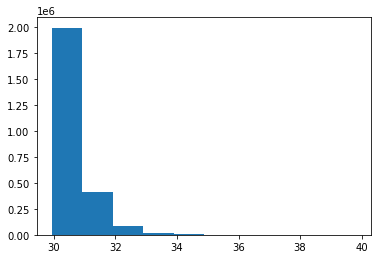

In [114]:
plt.hist(lnM)

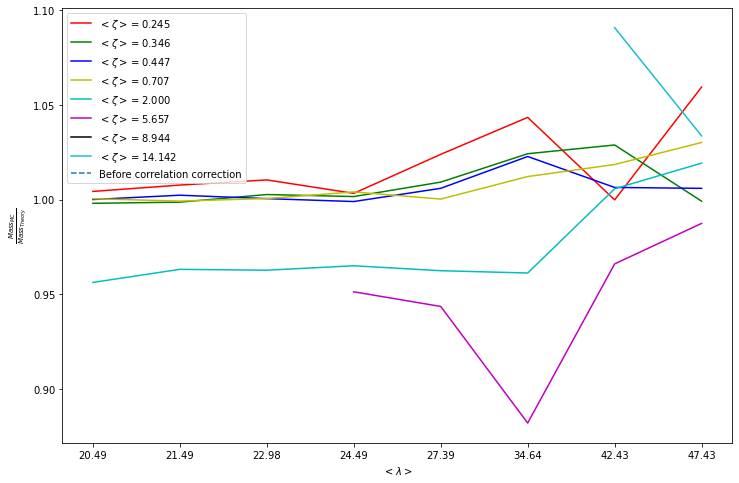

In [118]:
plt.figure(figsize=[12,8])
for i in range(NBINS):
    plt.plot(range(NBINS), np.exp(diff_array[i,:]), color=f'{color_list[i]}',label= f"$<\zeta> = {np.exp(SZ_array[i]):.3f}$")
    # plt.plot(range(NBINS), diff_array_nc[i,:], f'{color_list[i]}--')
plt.plot([], [], '--', label="Before correlation correction")    
plt.legend()
# locs, labels = plt.xticks()
plt.xticks(np.arange(0, NBINS, step=1), [f"{np.exp(lam):.2f}" for lam in lam_array])
plt.xlabel("$<\lambda>$")
plt.ylabel(r"$\frac{Mass_{MC}}{Mass_{Theory}}$")
# plt.title("Comparision Before&After r Correction")
plt.show()

In [81]:
r_array = [0,0.25,0.5,0.75,0.99]

diff_list = [None] * len(r_array)
lam_list = [None] * len(r_array)
SZ_list = [None] * len(r_array)
count_list = [None] * len(r_array)

for i in range(len(r_array)):
    mco = MonteCarloObservables(r_array[i],lnM, scatter_lam=scatter_lam, scatter_Mwl=scatter_Mwl)
    lam_list[i], SZ_list[i], diff_list[i], count_list[i] = mco.MC_calculate_mean_Mwl_given_lam_SZ(nbins = NBINS+1)

TypeError: MC_calculate_mean_Mwl_given_lam_SZ() missing 1 required positional argument: 'correction'

In [ ]:
diff_list

In [70]:
np.sum(np.array(diff_list), axis=0)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [71]:
np.sum(np.array(diff_list),axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [72]:
np.sum(np.array(diff_list), axis=2)

AxisError: axis 2 is out of bounds for array of dimension 1

In [ ]:
np.array(lam_list)

In [ ]:
#binned by lambda, marginalize SZ
diff_array_lambda = np.sum(np.array(diff_list), axis=1)/np.sum(np.invert(np.array(diff_list)==0),axis=1)
plt.figure(figsize=[12,8])
for i in range(len(lam_list[0])):
    plt.plot(range(len(r_array)), diff_array_lambda[:,i], label= f"$<\lambda> = {np.mean(np.array(lam_list)[:,i]):.3f}$")
    plt.legend()
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 5, step=1), [f"{r:.2f}" for r in r_array])
plt.xlabel("$r$")
plt.ylabel("Fractional Difference between Theory and MC")
plt.title("Fractional Difference Binned by $\lambda$")
plt.show()

In [ ]:
diff_array_SZ

In [ ]:
#binned by SZ, marginalize lambda
diff_array_SZ = np.sum(np.array(diff_list), axis=2)/np.sum(np.invert(np.array(diff_list)==0),axis=2)
plt.figure(figsize=[12,8])
for i in range(len(SZ_list[0])):
    plt.plot(range(len(r_array)), diff_array_SZ[:,i], label= f"$<\zeta> = {np.mean(np.array(SZ_list)[:,i]):.3f}$")
    plt.legend()
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 5, step=1), [f"{r:.2f}" for r in r_array])
plt.xlabel("$r$")
plt.ylabel("Fractional Difference between Theory and MC")
plt.title("Fractional Difference Binned by $\zeta$")
plt.show()